##### Study initial dataset

In [1]:
import os
from pathlib import Path
from pymatgen.io.cif import CifWriter
from mp_api.client import MPRester
import pandas as pd
import json
import ormsgpack as mp
import numpy as np
from matplotlib_venn import venn2
api_key=os.environ.get('MP_API_KEY')
ids = pd.read_csv("./data/material-data/mp-ids-46744.csv")
ids = [list(ids)[0]]+list(ids.iloc[:, 0])
print(len(ids))

46744


In [2]:
# my venn diagram for two sets
def venn(**kvarg):
    subsets = []
    set_labels = []
    for k,v in kvarg.items():
        subsets.append(set(v))
        set_labels.append(k)
    return venn2(subsets=subsets,set_labels=set_labels)
# get duplicates set of duplicates
def get_duplicates_list(a:list): 
    h = dict()
    for x in a:
        h.setdefault(x,0)
        h[x]+=1
    repeated = list()
    for k,v in h.items():
        if v>1:
            repeated+=[k for i in range(1,v)]
    return repeated

def get_duplicates_set(a:list):
    return set(get_duplicates_list(a))

In [3]:
# naive
with MPRester(api_key) as mpr:
    naive_docs = mpr.materials.search(material_ids=ids, fields=['material_id'])
    depr_naive_docs = mpr.materials.search(material_ids=ids, fields=['material_id'], deprecated=True)

/home/nodoteve/apps/pythom/miniconda/envs/cgcnn2/lib/python3.11/site-packages/mp_api/client/mprester.py:227: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving MaterialsDoc documents:   0%|          | 0/36074 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/563 [00:00<?, ?it/s]

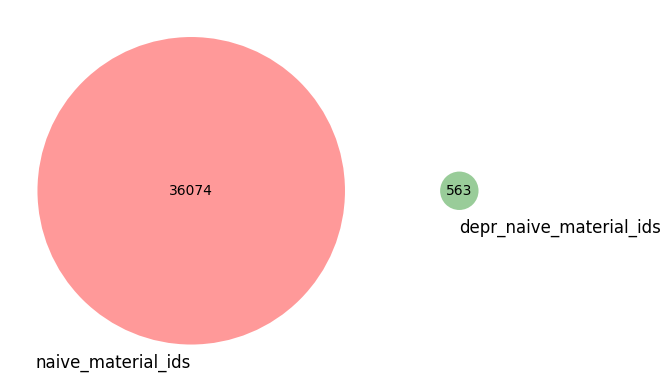

In [4]:
naive_material_ids = [str(d.material_id) for d in naive_docs]
naive_material_ids_repeated = get_duplicates_set(naive_material_ids)

depr_naive_material_ids = [str(d.material_id) for d in depr_naive_docs]
depr_naive_material_ids_repeated = get_duplicates_set(depr_naive_material_ids)
venn(naive_material_ids=naive_material_ids,
     depr_naive_material_ids=depr_naive_material_ids)

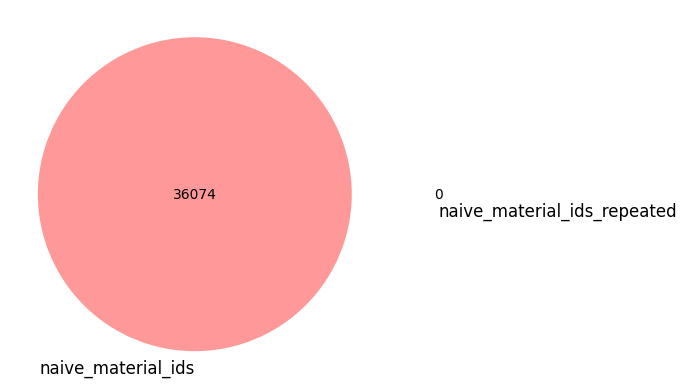

In [6]:
venn(naive_material_ids=naive_material_ids,
     naive_material_ids_repeated=naive_material_ids_repeated)

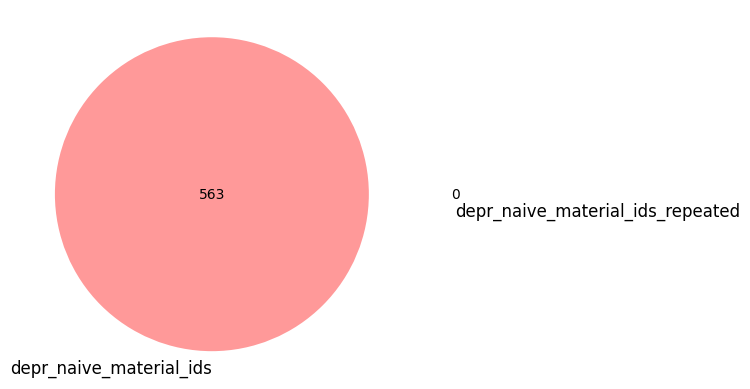

In [7]:
venn(depr_naive_material_ids=depr_naive_material_ids,
     depr_naive_material_ids_repeated=depr_naive_material_ids_repeated)

In [8]:
# non-naive approach
with MPRester(api_key) as mpr:
    docs = mpr.materials.search(task_ids=ids, fields=['material_id'])
    depr_docs = mpr.materials.search(task_ids=ids, fields=['material_id'],deprecated=True)

Retrieving MaterialsDoc documents:   0%|          | 0/46163 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/581 [00:00<?, ?it/s]

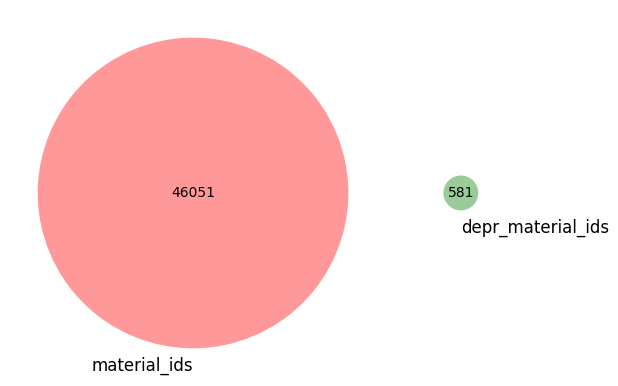

In [9]:
material_ids = [str(d.material_id) for d in docs]
material_ids_repeated = get_duplicates_set(material_ids)

depr_material_ids = [str(d.material_id) for d in depr_docs]
depr_material_ids_repeated = get_duplicates_set(depr_material_ids)

venn(material_ids=material_ids,
     depr_material_ids=depr_material_ids)

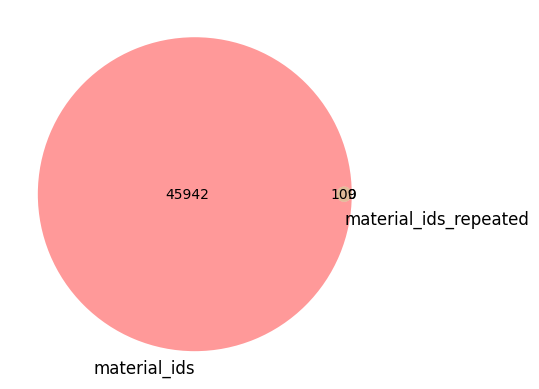

In [10]:
venn(material_ids=material_ids,
     material_ids_repeated=material_ids_repeated)

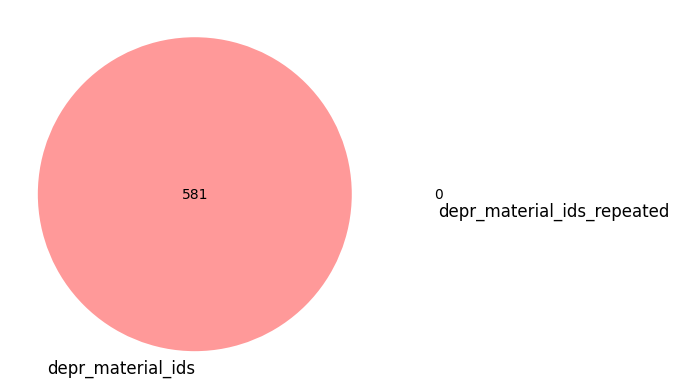

In [11]:
venn(depr_material_ids=depr_material_ids,
     depr_material_ids_repeated=depr_material_ids_repeated)

In [14]:
all_mids = list(set(material_ids).union(set(depr_material_ids)))
mids = list(set(material_ids))
depr_mids = list(set(depr_material_ids))
with MPRester(api_key) as mpr:
    # docs2 = mpr.materials.search(material_ids=mids, fields=["material_id", "task_ids"])
    # depr_docs2 = mpr.materials.search(material_ids=depr_mids, fields=["material_id", "task_ids"], deprecated=True)
    # equivalent
    all_docs2 = mpr.materials.search(material_ids=all_mids, fields=["material_id", "task_ids"])
    depr_all_docs2 = mpr.materials.search(material_ids=all_mids, fields=["material_id", "task_ids"], deprecated=True)

Retrieving MaterialsDoc documents:   0%|          | 0/46051 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/581 [00:00<?, ?it/s]

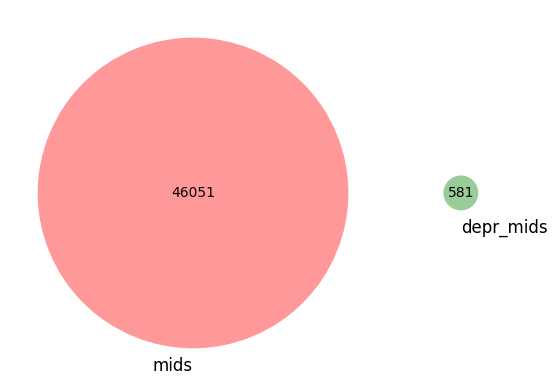

In [15]:
mids = [str(d.material_id) for d in all_docs2]
depr_mids = [str(d.material_id) for d in depr_all_docs2]
venn(mids=mids,depr_mids=depr_mids)
# => mids are unique

In [16]:
mtids = [(str(d.material_id),[str(x) for x in d.task_ids]) for d in all_docs2]
depr_mtids = [(str(d.material_id),[str(x) for x in d.task_ids]) for d in depr_all_docs2]
# keep only task_ids from (initial) ids.
sids = set(ids)
redused_mtids = [(m,[x for x in t if x in sids]) for m,t in mtids]
redused_depr_mtids = [(m,[x for x in t if x in sids]) for m,t in depr_mtids]

# flatten
all_tids = []
for m,t in redused_mtids:
    all_tids += t
for m,t in redused_depr_mtids:
    all_tids += t
print(len(get_duplicates_set(all_tids)))
# => correspondence between tids and mids not strictly obeys the law that there is only one mid for the given tid. (but it should)
# Explanation: duplicates appears after addition of deprecated part => deprecation is a task_id property,
# but not the resulting material_id property. Therefore, some undeprecated mids can be accessed by deprecated tids.

0


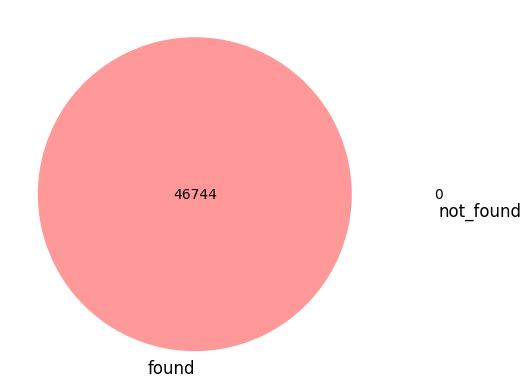

In [17]:
# compare with (initial) ids

# create map ids -> material_ids
t2m = dict()
for m,t in mtids:
    for x in t:
        t2m[x]=m
for m,t in depr_mtids:
    for x in t:
        t2m[x]=m
found=[x for x in ids if x in t2m]
not_found=[x for x in ids if x not in t2m]
venn(found=found,not_found=not_found)

In [18]:
# set theoretical image of ids after t2m
img = [t2m[x] for x in ids]

46632 112 109


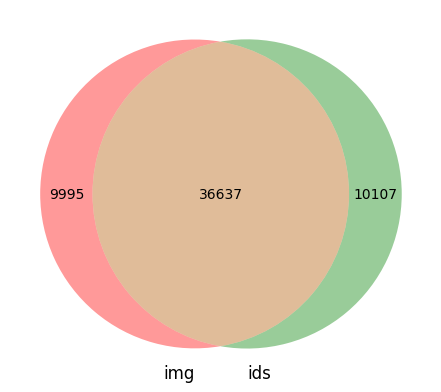

In [19]:
print(len(set(img)),len(get_duplicates_list(img)),len(get_duplicates_set(img)))
venn(img=img, ids=ids)
# => Actual number of duplicates (data leak) in article implementation is about 830 ids (~1.8%)

#### Reimplement dataset with data leak, and then without.


In [24]:
# def save_structure_to_cif(structure, output_file):
#     with open(output_file, "w") as f:
#         cif_writer = CifWriter(structure)
#         cif_writer.write_file(f.name)


cifs_file = './data/root/data/cifs.bin'
def save_structures_to_bin(structures: dict, output_file=cifs_file):
    with open(output_file, "wb") as f:
        f.write(mp.packb(structures, option=mp.OPT_NON_STR_KEYS))

props_file = './data/root/data/props.bin'
def save_properties_to_bin(properties: dict, output_file=props_file):
    with open(output_file, "wb") as f:
        f.write(mp.packb(properties, option=mp.OPT_NON_STR_KEYS))

t2m_file = './data/root/data/t2m.bin'
save_properties_to_bin(t2m,t2m_file)
# fields=['formation_energy_per_atom']
fields = [
    "energy_per_atom",
    "formation_energy_per_atom",
    "band_gap",
    "efermi",
    "k_voigt",
    "k_reuss",
    "k_vrh",
    "g_voigt",
    "g_reuss",
    "g_vrh",
    "homogeneous_poisson",
]
depr_docs=[]
docs=[]
def download_all():
    global docs,depr_docs
    with MPRester(api_key) as mpr:
        docs = mpr.materials.summary.search(
            material_ids=img, fields=fields + ["structure", "material_id"]
        )
        depr_docs = mpr.materials.summary.search(material_ids=img,
                                             fields=fields + ["structure", "material_id"],
                                             deprecated=True)
    all_docs = depr_docs+docs
    props = dict()
    # faster:
    cifs = dict()
    for d in all_docs:
        # slower:
        # output_file = f"./data/root/data/{d.material_id}.cif"
        # save_structure_to_cif(d.structure, output_file)
        # faster:
        cifs[d.material_id] = d.structure.as_dict()
        props[d.material_id] = d.model_dump(include=fields)
    # faster:
    save_structures_to_bin(cifs)
    save_properties_to_bin(props)
    # uncorrected_energy_per_atom energy_per_atom formation_energy_per_atom band_gap efermi
    #  see https://docs.materialsproject.org/methodology/materials-methodology/elasticity/ k <-> bulk, g <-> shear
    # k_vrh g_vrh homogeneous_poisson
download_all()

/home/nodoteve/apps/pythom/miniconda/envs/cgcnn2/lib/python3.11/site-packages/mp_api/client/mprester.py:227: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving SummaryDoc documents:   0%|          | 0/46163 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/581 [00:00<?, ?it/s]

In [1]:
# compress with zstd
import zstandard as zstd
cifs_file = './data/root/data/cifs.bin'
props_file = './data/root/data/props.bin'

def compress_all():
    with open(cifs_file, "rb") as f:
        res = zstd.compress(f.read(), level=10)
    with open("./data/root/cifs.zstd", "wb") as f:
        f.write(res)
    with open(props_file, "rb") as f:
        res = zstd.compress(f.read(), level=10)
    with open("./data/root/props.zstd", "wb") as f:
        f.write(res)


# compress_all()



def uncompress_all():
    with open("./data/root/cifs.zstd", "rb") as f:
        res = zstd.decompress(f.read())
    with open(cifs_file, "wb") as f:
        f.write(res)
    with open("./data/root/props.zstd", "rb") as f:
        res = zstd.decompress(f.read())
    with open(props_file, "wb") as f:
        f.write(res)


uncompress_all()

In [30]:
# print data statistics for first dataset
basedir = './data/root/data/'

# propfiles = os.listdir(basedir)
# def load_properties_from_json(file):
#     filename = os.path.basename(file)
#     with open(basedir + file, "rb") as f:
#         properties = json.load(f)
#         return (filename, properties)
#     return None


def load_properties_from_bin(file):
    with open(file, "rb") as f:
        properties = mp.unpackb(f.read())
        return properties
    return None

# propdata = dict()
# for file in propfiles:
#     name,prop=load_properties_from_json(file)
#     for key in prop.keys():
#         propdata.setdefault(key,[])
#         propdata[key].append(prop[key])

full_df = pd.DataFrame(load_properties_from_bin(basedir + "props.bin")).transpose()
import numpy as np

# for moduli in ["k_voigt", "k_reuss", "k_vrh", "g_voigt", "g_reuss", "g_vrh"]:
#     full_df[moduli] = np.log(full_df[moduli])
full_df.describe()
# f.to_csv('./test_missing.csv')

,energy_per_atom,formation_energy_per_atom,band_gap,efermi,k_voigt,k_reuss,k_vrh,g_voigt,g_reuss,g_vrh,homogeneous_poisson
count,46055.000000,46055.000000,46632.000000,46632.000000,0.0,0.0,0.0,0.0,0.0,0.0,8802.000000
mean,-9.402272,-1.703857,1.394342,2.901569,NaN,NaN,NaN,NaN,NaN,NaN,0.298029
std,7.408867,1.047019,1.659040,2.674768,NaN,NaN,NaN,NaN,NaN,NaN,2.460508
min,-83.024212,-4.510049,0.000000,-14.017281,NaN,NaN,NaN,NaN,NaN,NaN,-179.362000
25%,-8.646992,-2.502314,0.000000,1.084994,NaN,NaN,NaN,NaN,NaN,NaN,0.250000
50%,-7.329141,-1.857242,0.699550,2.640544,NaN,NaN,NaN,NaN,NaN,NaN,0.294000
75%,-5.984656,-0.746991,2.487525,4.612346,NaN,NaN,NaN,NaN,NaN,NaN,0.339000
max,-0.310334,4.310576,16.586400,17.758767,NaN,NaN,NaN,NaN,NaN,NaN,82.881000


In [ ]:
# w?
# mp-756006 - example
# energy_per_atom,formation_energy_per_atom problems (unable to solve, seems to be deleted due to deprectaion)

In [ ]:
# train on all properties for 1st dataset 

In [27]:
import numpy as np
from subprocess import run
import shutil as st

resdict = dict()
maedict = dict()
reference_csv = {
    "mp-ids-3402.csv": [
        "k_voigt",
        "k_reuss",
        "k_vrh",
        "g_voigt",
        "g_reuss",
        "g_vrh",
        "homogeneous_poisson",
    ],
    "mp-ids-27430.csv": ["band_gap"],
    "mp-ids-46744.csv": ["energy_per_atom", "formation_energy_per_atom", "efermi"],
}


def set_property_to_ids(df: pd.DataFrame, property: str):
    # nids = df[property].isna()
    df[property].dropna().to_csv("./data/root/data/id_prop.csv", index=True, header=False)

def prepare_csv(csv: str, df: pd.DataFrame, prop: str):
    # st.move("./data/material-data/" + csv, "./data/root/data/id_prop.csv")
    set_property_to_ids(df, prop)

t2m_file = './data/root/data/t2m.bin'
t2m = load_properties_from_bin(t2m_file)

def get_df_for_csv(csv:str):
    global t2m, full_df
    ids = pd.read_csv("./data/material-data/" + csv)
    ids = [list(ids)[0]]+list(ids.iloc[:, 0])
    df = pd.DataFrame()
    for t in ids:
        m = t2m[t]
        df=pd.concat([df,full_df.loc[[m]]])
    return df




In [28]:
df = get_df_for_csv('mp-ids-3402.csv')
df.describe()

,energy_per_atom,formation_energy_per_atom,band_gap,efermi,k_voigt,k_reuss,k_vrh,g_voigt,g_reuss,g_vrh,homogeneous_poisson
count,3402.000000,3402.000000,3402.000000,3402.000000,0.0,0.0,0.0,0.0,0.0,0.0,2950.000000
mean,-12.147303,-0.952483,0.678811,4.814247,NaN,NaN,NaN,NaN,NaN,NaN,0.282928
std,9.521122,0.956267,1.353280,2.744502,NaN,NaN,NaN,NaN,NaN,NaN,0.136696
min,-56.285134,-4.223837,0.000000,-4.654093,NaN,NaN,NaN,NaN,NaN,NaN,-3.500000
25%,-15.073407,-1.289773,0.000000,3.001713,NaN,NaN,NaN,NaN,NaN,NaN,0.242000
50%,-8.434996,-0.592026,0.000000,5.175226,NaN,NaN,NaN,NaN,NaN,NaN,0.283000
75%,-6.321394,-0.302318,0.742900,6.931447,NaN,NaN,NaN,NaN,NaN,NaN,0.324000
max,-0.858596,2.756673,8.716100,12.401693,NaN,NaN,NaN,NaN,NaN,NaN,4.017000


In [ ]:
df = get_df_for_csv('mp-ids-3402.csv')
df.describe()

,energy_per_atom,formation_energy_per_atom,band_gap,efermi,k_voigt,k_reuss,k_vrh,g_voigt,g_reuss,g_vrh,homogeneous_poisson
count,3378.000000,3378.000000,3402.000000,3402.000000,3401.000000,3400.000000,3401.000000,3401.000000,3400.000000,3401.000000,3401.000000
mean,-6.215949,-0.959954,0.678802,4.812236,4.535167,4.465140,4.507788,3.863505,3.667208,3.782168,0.284104
std,2.135439,0.965489,1.353408,2.743824,0.770992,0.860045,0.794463,0.777641,0.903429,0.809492,0.060879
min,-12.958130,-4.298431,0.000000,-4.654093,1.288517,0.426736,1.269426,0.976944,-0.639653,0.886284,-0.124269
25%,-7.831029,-1.296117,0.000000,3.002715,4.086537,4.009625,4.044191,3.397700,3.143085,3.286557,0.245585
50%,-6.295464,-0.596287,0.000000,5.173001,4.710932,4.681821,4.691549,3.979850,3.835428,3.898296,0.286754
75%,-4.537358,-0.306151,0.737175,6.923026,5.113175,5.098365,5.103428,4.424533,4.331358,4.378000,0.323743
max,-0.483234,2.756673,8.695900,12.401693,6.687777,6.639926,6.664137,5.958360,5.939104,5.948779,0.467523


In [29]:
for csv in reference_csv.keys():
    df = get_df_for_csv(csv)

    for prop in reference_csv[csv]:
        prepare_csv(csv, df, prop)

        res = run(
            "conda run -n cgcnn2 python main.py --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 ./data/root/data/",
            capture_output=True,
            text=True,
            shell=True,
        )
        # result = run(['ls'], capture_output=True, text=True)
        # Write the contents of the stdout (standard output) to the file.
        resdict[prop] = res.stdout
        maedict[prop] = resdict[prop].split("** MAE ")[-1].replace('\n','')
        print(prop, maedict[prop])

        st.move("checkpoint.pth.tar", "./trained/" + prop + "_check.pth.tar")
        st.move("model_best.pth.tar", "./trained/" + prop + "_best.pth.tar")
        st.move("test_results.csv", "./trained/" + prop + "_results.csv")
        
        with open("train_outputs.json", "w") as f:
            json.dump(resdict, f)
        pd.DataFrame(maedict, index=['MAE']).transpose().to_csv('train_maes.csv')

k_voigt 4.76837158203125e-07


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint.pth.tar'

In [ ]:
def prepare_csv_no_leak(csv: str, df: pd.DataFrame, prop: str):
    part_df=df[prop].dropna()
    part_df=part_df.groupby(part_df.index).first()
    part_df.to_csv("./data/root/data/id_prop.csv", index=True, header=False)


In [ ]:
for csv in reference_csv.keys():
    df = get_df_for_csv(csv)

    for prop in reference_csv[csv]:
        prepare_csv(csv, df, prop)

        res = run(
            "conda run -n cgcnn2 python main.py --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 ./data/root/data/",
            capture_output=True,
            text=True,
            shell=True,
        )
        # result = run(['ls'], capture_output=True, text=True)
        # Write the contents of the stdout (standard output) to the file.
        resdict[prop] = res.stdout
        maedict[prop] = resdict[prop].split("** MAE ")[-1].replace('\n','')
        print(prop, maedict[prop])

        st.move("checkpoint.pth.tar", "./trained/" + prop + "_check.pth.tar")
        st.move("model_best.pth.tar", "./trained/" + prop + "_best.pth.tar")
        st.move("test_results.csv", "./trained/" + prop + "_results.csv")
        
with open("train_outputs.json", "w") as f:
    json.dump(resdict, f)
pd.DataFrame(maedict).to_csv('train_maes.csv')

k_voigt 0.146


k_reuss 0.203


k_vrh 0.167


g_voigt 0.204


g_reuss 0.307


g_vrh 0.228


homogeneous_poisson 0.034


band_gap 0.520


energy_per_atom 0.123


formation_energy_per_atom 0.080


efermi 0.464




On recent MT db version for all ids:

In [2]:
fields = [
    "energy_per_atom",
    "formation_energy_per_atom",
    "band_gap",
    "efermi",
    "k_voigt",
    "k_reuss",
    "k_vrh",
    "g_voigt",
    "g_reuss",
    "g_vrh",
    "homogeneous_poisson",
]
# (undeprecated cifs and props)
all_props_file = "./data/root/data/db_props.bin"
all_cifs_file = "./data/root/data/db_cifs.bin"
def save_structures_to_bin(structures: dict, output_file=all_cifs_file):
    with open(output_file, "wb") as f:
        f.write(mp.packb(structures, option=mp.OPT_NON_STR_KEYS))

props_file = './data/root/data/props.bin'
def save_properties_to_bin(properties: dict, output_file=all_props_file):
    with open(output_file, "wb") as f:
        f.write(mp.packb(properties, option=mp.OPT_NON_STR_KEYS))
from timeit import default_timer as timer
docs = [] 
def download_all():
    global docs
    with MPRester(api_key) as mpr:
        docs = mpr.materials.summary.search(
            fields=fields + ["structure", "material_id"]
        )
    props = dict()
    cifs = dict()
    for d in docs:
        cifs[str(d.material_id)] = d.structure.as_dict()
        props[str(d.material_id)] = d.model_dump(include=fields)
    save_structures_to_bin(cifs)
    save_properties_to_bin(props)
    # uncorrected_energy_per_atom energy_per_atom formation_energy_per_atom band_gap efermi
    #  see https://docs.materialsproject.org/methodology/materials-methodology/elasticity/ k <-> bulk, g <-> shear
    # k_vrh g_vrh homogeneous_poisson


# download_all()

In [ ]:
all_props_file_zstd = "./data/root/db_props.zstd"
all_cifs_file_zstd = "./data/root/db_cifs.zstd"


def compress_all():
    with open(cifs_file, "rb") as f:
        res = zstd.compress(f.read(), level=10)
    with open(all_props_file_zstd, "wb") as f:
        f.write(res)
    with open(props_file, "rb") as f:
        res = zstd.compress(f.read(), level=10)
    with open(all_props_file_zstd, "wb") as f:
        f.write(res)

compress_all()

def uncompress_all():
    with open(all_cifs_file_zstd, "rb") as f:
        res = zstd.decompress(f.read())
    with open(cifs_file, "wb") as f:
        f.write(res)
    with open(all_props_file_zstd, "rb") as f:
        res = zstd.decompress(f.read())
    with open(props_file, "wb") as f:
        f.write(res)


# uncompress_all()

In [6]:
import msgpack as mp
# create DF
def load_properties_from_bin(file):
    with open(file, "rb") as f:
        properties = mp.unpackb(f.read())
        return properties
    return None

full_df = pd.DataFrame(load_properties_from_bin(all_props_file)).transpose()

for moduli in ["k_voigt", "k_reuss", "k_vrh", "g_voigt", "g_reuss", "g_vrh"]:
    full_df[moduli] = np.log(full_df[moduli])
full_df.describe()

/home/nodoteve/apps/pythom/miniconda/envs/cgcnn2/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,energy_per_atom,formation_energy_per_atom,band_gap,efermi,k_voigt,k_reuss,k_vrh,g_voigt,g_reuss,g_vrh,homogeneous_poisson
count,154718.000000,154718.000000,154718.000000,154678.000000,7090.000000,7062.000000,7088.000000,7001.000000,6762.000000,6913.000000,7108.000000
mean,-6.265759,-1.455087,1.055169,3.068901,4.380086,4.240804,4.329746,3.660874,3.411944,3.557844,0.287040
std,1.862117,1.201848,1.503758,2.772111,0.932448,1.152582,0.988528,0.969911,1.243779,1.041220,1.847910
min,-18.488548,-11.867881,0.000000,-14.017281,-2.619888,-2.619888,-2.619888,-3.839952,-6.026329,-4.667912,-130.933087
25%,-7.585424,-2.434546,0.000000,1.268615,3.896122,3.782383,3.832884,3.167007,2.881696,3.025152,0.249817
50%,-6.516871,-1.558728,0.083000,3.026354,4.604472,4.550343,4.575511,3.819144,3.654710,3.720620,0.292658
75%,-5.103024,-0.499446,1.858600,4.902281,5.063025,5.041300,5.047488,4.328980,4.263000,4.296224,0.333117
max,-0.000760,8.984754,17.891400,19.414179,6.687777,6.639926,6.664137,6.271220,8.789639,8.100217,77.046915


In [8]:
def set_property_to_ids(df: pd.DataFrame, prop: str):
    part_df = df[prop].dropna()
    print(part_df.head())
    part_df = part_df.groupby(part_df.index).first()
    print(part_df.head())
    part_df.to_csv("./data/root/data/id_prop.csv", index=True, header=False)

In [ ]:
# for prop in fields:
#     set_property_to_ids(full_df, prop)
#     res = run(
#         "conda run -n cgcnn2 python main.py --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 ./data/root/data/",
#         capture_output=True,
#         text=True,
#         shell=True,
#     )
#     resdict[prop] = res.stdout
#     maedict[prop] = resdict[prop].split("** MAE ")[-1].replace('\n','')
    
#     print(prop, maedict[prop])

#     st.move("checkpoint.pth.tar", "./trained/" + prop + "_check.pth.tar")
#     st.move("model_best.pth.tar", "./trained/" + prop + "_best.pth.tar")
#     st.move("test_results.csv", "./trained/" + prop + "_results.csv")
        
# with open("train_outputs.json", "w") as f:
#     json.dump(resdict, f)
# pd.DataFrame(maedict).to_csv('train_maes.csv')

In [7]:
# sort out crystals with warnings:
from pymatgen.core import Structure
from cgcnn.data import get_all_neighbors
ill = set()
with open('./data/root/data/db_cifs.bin','rb') as f:
    cifs = mp.unpackb(f.read())
    for i, row in full_df.iterrows():
        crystal = Structure.from_dict(cifs[i])
        all_nbrs = get_all_neighbors(crystal, r=8, include_index=True)
        all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]
        max_num_nbr=12
        for nbr in all_nbrs:
            if len(nbr) < max_num_nbr:
                ill.add(i)
non_ill_df = full_df.drop(list(ill), axis='index')
set_property_to_ids(non_ill_df, 'formation_energy_per_atom')
non_ill_df.to_csv('non_ill_df.csv', index=True)

In [10]:
set_property_to_ids(non_ill_df, 'energy_per_atom')

mp-20998     -3.016978
mp-1175256   -6.896493
mp-2865      -4.541226
mp-850956    -8.043878
mp-1079437   -7.208301
Name: energy_per_atom, dtype: float64
mp-1       -0.856633
mp-10      -4.546721
mp-100     -9.781034
mp-1000    -4.534715
mp-10000   -9.212830
Name: energy_per_atom, dtype: float64


In [ ]:
for prop in fields:
    set_property_to_ids(non_ill_df, prop)
    res = run(
        "conda run -n cgcnn2 python main.py --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 ./data/root/data/",
        capture_output=True,
        text=True,
        shell=True,
    )
    resdict[prop] = res.stdout
    maedict[prop] = resdict[prop].split("** MAE ")[-1].replace('\n','')
    
    print(prop, maedict[prop])

    st.move("checkpoint.pth.tar", "./trained/" + prop + "_check.pth.tar")
    st.move("model_best.pth.tar", "./trained/" + prop + "_best.pth.tar")
    st.move("test_results.csv", "./trained/" + prop + "_results.csv")
        
with open("train_outputs.json", "w") as f:
    json.dump(resdict, f)
pd.DataFrame(maedict).to_csv('train_maes.csv')